In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")

LReg (generic function with 1 method)

Three Level Deferred Correction

In [3]:
# Function for 3-level reference solution  (one way)

function Ref3DC(f, a, b, u0, N)
    dt=(b-a)/N
    t=(0:N)*dt
    m=2
    DT1=m*dt
    DT2=m*DT1
    U=zeros(1, N+1, 3)
    
    U[1, 1, 1]=u0
    U[1, 1, 2]=u0
    U[1, 1, 3]=u0

    for i=1:m^2:N
        U[1, i, 2]=U[1, i, 3] # Injection from the third level
        for j=i:m:i+2
            U[1, j, 1]=U[1, j, 2] # Injection from the second level
            for k=j:j+1
                U[1, k+1, 1]=U[1, k, 1]+dt*f(t[k], U[1, k, 1])
            end
            U[1, j+2, 2]= U[1, j, 2] + DT1*(f(t[j], U[1, j, 2])-f(t[j], U[1, j, 1])) + Lagrange(t[j:j+2], f(t[j:j+2], U[1, j:j+2, 1]), t[j], t[j+2])
        end
        U[1, i+4, 3]=U[1, i, 3] + DT2*(f(t[i], U[1, i, 3])-f(t[i], U[1, i, 2]))+ Lagrange(t[i:m:i+4], f(t[i:m:i+4], U[1, i:m:i+4, 2]), t[i], t[i+4])
    end
        
    return  U, t
end

Ref3DC (generic function with 1 method)

convergence order = 2.949487251178418


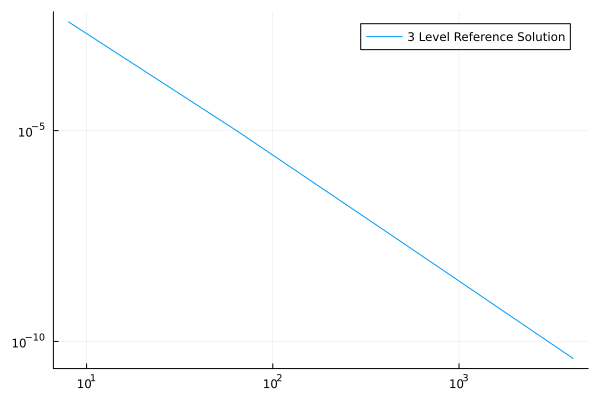

In [5]:
# Convergence rate test of reference solution
using LinearAlgebra

u0 = 1.0
lambda= 1
a=0
b=1.0
K = 4
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
#f(t, y) = t .* y.^2 .* cos.(t) .^2

f(t, u)= u

for k in 1:K
    
    N = 8^k
    
    ns[k]=N
    U, t= Ref3DC(f, a, b, u0, N)
    # exact= -8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t))
    exact= u0*exp.(t)
    err[k] = norm(exact[1:m^2:end] .- U[1, 1:m^2:end, 3], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="3 Level Reference Solution")
display(plot!(legend=:topright))

In [7]:
function inter(a, b, u0, dt, m)
    uk=zeros(m+1)
    uk[1]=u0
    tv=a:dt:b
    for i=1:m
        uk[i+1]=uk[i]+dt* f(tv[i], uk[i])
    end
    return uk[end]
end

inter (generic function with 1 method)

In [9]:
function threelevel(f, a, b, N, u0, H, K)
    
    dt = (b - a)/ N
    m = 2 
    DT1 = m*dt
    DT2 = m*DT1
    u = zeros(1, N + 1, K + 1)
    u[1, 1, 1] = u0
    ps2=5:m^2:N
    ps = 3:m:N
    u[1, ps2, 1] = rand(length(ps2)) # initializing random values
    t = (0:N)*dt
    up = zeros(N + 1)
    up[1] = u0
    uc = zeros(1, N + 1, K+1)
    uc[1, 1, 1] = u0
    uc[1, ps, 1] = rand(length(ps)) # initializing random values

    for k in 1:K
        
        u[1, 1, k+1] = u0
        uc[1, 1, k+1]= u0
        
        # F-relaxation on level 1
        for i=1:m:N
            up[i]=uc[1, i, k] # Injection from Level 2
            up[i+1]= H(t[i], t[i+1], up[i], dt, m-1) # One step solver
        end
        # C-relaxation on level 1
        for j=2:2:N
            up[j+1]= H(t[j], t[j+1], up[j], dt, m-1)  # One step solver
        end

        # F-relaxation on level 2
        for n =1:m^2:N
            uc[1, n, k+1]=u[1, n, k] # Injection from the third level
            uc[1, n+2, k+1] = uc[1, n, k+1] + DT1*(f(t[n], uc[1, n, k+1]) - f(t[n], uc[1, n, k])) + Lagrange(t[n:n+2], f(t[n:n+2], [uc[1, n, k]; up[n+1:n+2]]), t[n], t[n+2])
        end
        # C-relaxation on level 2
        for l=3:m^2:N
            uc[1, l+2, k+1] = uc[1, l, k+1] + DT1*(f(t[l], uc[1, l, k+1]) - f(t[l], uc[1, l, k])) + Lagrange(t[l:l+2], f(t[l:l+2], [uc[1, l, k]; up[l+1:l+2]]), t[l], t[l+2])
        end

        # Coarse-grid correction on level 3
        for z=1:m^2:N
            uc[1, z, k+1]=u[1, z, k]
            u[1, z+4, k+1]=u[1, z, k+1]+ DT2*(f(t[z], u[1, z, k+1])-f(t[z], u[1, z, k]))+Lagrange(t[z:m:z+4], f(t[z:m:z+4], uc[1, z:m:z+4, k+1]), t[z], t[z+4])
        end
        
    end

    return  u, t
end

threelevel (generic function with 1 method)

In [ ]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
#f(t, u) = t .* u.^2 .* cos.(t) .^2
f(t, u)= u
N = 16
K = 10 # Number of Iterations
m = 2
err=zeros(K+1)
u, t= threelevel(f, a, b, N, u0, inter, K) # Approximate Solution
U, t = Ref3DC(f, a, b, u0, N) # Reference Solution
for k=1:K+1
    err[k]= norm( U[1, 1:m^2:end, 3] .- u[1, 1:m^2:end, k], Inf ) .+10^(-16)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error", label=" 3 Level Finite Step Convergence")

In [ ]:
using LinearAlgebra

u0 = 1.0
lambda= 1
a=0
b=1.0
K = 4
itr=10
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
f(t, y) = t .* y.^2 .* cos.(t) .^2

for k in 1:K
    
    N = 8^k
    
    ns[k]=N
    u, t= threelevel(f, a, b, N, u0, inter, itr)
    exact= -8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t))
    err[k] = norm(exact[1:m^2:end] .- u[1, 1:m^2:end, itr], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="3 Level DC")
display(plot!(legend=:topright))